In [1]:
import pyathena as pa
import numpy as np
import matplotlib.pyplot as plt
from for_hii import hii
from pathlib import Path
import yt
import sys
sys.path.insert(0,'/home/cjlee/practice/athena/vis/python')
import athena_read
from astropy.io import ascii
import matplotlib as mpl
from astropy import units as au
from astropy.table import QTable
from astropy import constants as const
from add_fields_hii import add_fields
import yt.units as yu
from mpl_toolkits.axes_grid1 import AxesGrid
from pyathena.io.timing_reader import TimingReader
import pickle
mpl.rcParams['font.size'] = 16
#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['xtick.top'] = True
#mpl.rcParams['ytick.right'] = True
yt.set_log_level(50)

In [2]:
path_='/data/cjlee/hii/various_nH0_Qi'
datapath=Path(path_)
pathlist=list(datapath.glob('*hii*'))
path=pathlist[24]
path

PosixPath('/data/cjlee/hii/various_nH0_Qi/hii_Q49.0n2.0_nx_256_fdt_0.50_test3')

In [3]:
s=pa.LoadSim(str(path))
h=pa.read_hst(s.files['hst'])

In [4]:
def get_data(s, num):
    # num = s.nums[100]
    d = s.load_hdf5(num,load_method='yt')
    add_fields(d,s)
    dd=d.all_data()
    u = s.u
    dvol = s.domain['dx'].prod()
    N=s.par['mesh']['nx1']**3
    dN=int(N/128**3)
    ind=range(0,N,dN)
    # Derived fields
    dd['radius'] = np.sqrt(dd['x']**2 + dd['y']**2 + dd['z']**2)
    # dd['rho_neu'] = dd['rho']*dd['r0']
    # dd['rho_ion'] = dd['rho']*(1 - dd['r0'])
    
    # Sort cells in ascending order
    idx_ion = dd['r0'] < 0.5
    idx = np.argsort(dd['radius'].flatten())
    
    rr = dict()
    rr['r'] = (dd['radius'].flatten()[idx])[ind]
    rr['Mion_r'] = ((dd['rho'].value*idx_ion).flatten()[idx].cumsum()*dvol*u.mass)[ind]
    rr['Mneu_r'] = ((dd['rho'].value*~idx_ion).flatten()[idx].cumsum()*dvol*u.mass)[ind]
    rr['Pion_r'] = ((dd['rad_pressure_grad'].value*idx_ion).flatten()[idx].cumsum()*dvol)[ind]
    rr['Pneu_r'] = ((dd['rad_pressure_grad'].value*~idx_ion).flatten()[idx].cumsum()*dvol)[ind]
    rr['Iph_r'] = (ad['Iph'].flatten()[idx].cumsum()*dvol)[ind]
    rr['Rec_r'] = (ad['Rec'].flatten()[idx].cumsum()*dvol)[ind]
    
    rr['fV_neu'] = idx_ion.sum()/dd['r0'].size
    rr['fV_ion'] = 1.0 - rr['fV_neu']
    xl=-dd['rho_hi_dot'].value.flatten()[idx]
    rr['dot_rho_ev'] = xl[ind]
    rr['dot_M_ev'] = (xl.cumsum()*dvol*u.mass/u.time)[ind]
    rr['time'] = d.current_time.value
    
    return dd, rr

In [4]:
def find_r(x,y,per):
    cut=np.max(y)*per
    region=np.where(y>=cut)
    return np.min(x[region])
datapath_=Path(str(path)+'/evap_dictionary')
pathlist_dict=list(datapath_.glob('*t*'))
dict_list=[]
for i in range(0,len(pathlist_dict),1):
    print(i)
    ph=str(pathlist_dict[i])
    with open(ph, 'rb') as fr:
        rr = pickle.load(fr)
    dict_list.append(rr)
    
r_evap={'time':np.array([]),'radius':np.array([])}
r_neu={'time':np.array([]),'radius':np.array([])}
r_ion={'time':np.array([]),'radius':np.array([])}

tlim = s.par['time']['tlim']

cut=10
for rr in dict_list:
    
    r_evap['time']=np.hstack([r_evap['time'],rr['time']])
    r_evap['radius']=np.hstack([r_evap['radius'],find_r(rr['r'],rr['dot_M_ev'],0.95)])
    
    r_neu['time']=np.hstack([r_neu['time'],rr['time']])
    r_neu['radius']=np.hstack([r_neu['radius'],find_r(rr['r'],rr['Mneu_r'],0.95)])
    r_ion['time']=np.hstack([r_ion['time'],rr['time']])
    r_ion['radius']=np.hstack([r_ion['radius'],find_r(rr['r'],rr['Mion_r'],0.95)])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140


In [5]:
unit=s.par['units']['mass_cgs']*au.g*(s.par['units']['length_cgs']/s.par['units']['time_cgs']*au.cm/au.s)**2/s.par['units']['time_cgs']/au.s
L=s.par['problem']['Qi']*s.par['photchem']['hnu[0]']*au.eV/au.s
t1=QTable.read(str(path)+'/outflow_hst',format='latex')

f_esc=(t1['radiation_Energy_total']*(s.u.energy/s.u.time)).to(au.eV/au.s)/L

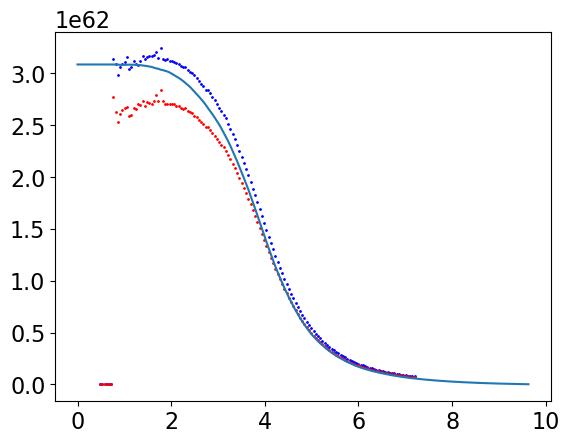

In [6]:
for i in range(0,len(dict_list),1):
    plt.plot(dict_list[i]['time'],(dict_list[i]['Rec_r'][-1]),'bo',ms=1)
    plt.plot(dict_list[i]['time'],(dict_list[i]['Iph_r'][-1]),'ro',ms=1)
plt.plot(t1['time_total'],(1-f_esc)*1e+49*s.par['units']['time_cgs'])

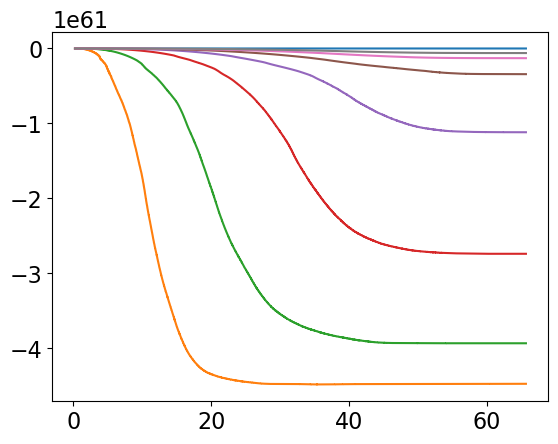

In [7]:
for i in range(0,len(dict_list),20):
    evap=(dict_list[i]['Iph_r']-dict_list[i]['Rec_r'])
    plt.plot(dict_list[i]['r'],evap)

In [16]:
ds=s.load_hdf5(30,load_method='yt')

In [17]:
energy_density = s.u.energy_density.cgs.value
mean_mass_per_hydrogen = yu.mass_hydrogen_cgs*s.u.muH
sig_pi_H0=s.par['photchem']['sigma_pi_HI[0]']*yu.cm**2
c=2.9979246*10**10*yu.cm/yu.s
hnu=s.par['photchem']['hnu[0]']*yu.eV
def alphaB(Tgas):
    return (2.59e-13*(Tgas*1e-4)**-0.7)*yu.cm**3/yu.s

In [18]:
def _Erad_LyC(field, data):
    return data['Er_rayt0']*energy_density*yu.erg/yu.cm**3
def _Iph(field,data):
    return (data['athena_pp','r0']*data['gas','density']/mean_mass_per_hydrogen)*sig_pi_H0*c*data['athena_pp','Erad_LyC']/hnu
def _Rec(field,data):
    return ((1-data['athena_pp','r0'])*data['gas','density']/mean_mass_per_hydrogen)**2*alphaB(data['temperature'].value)

In [19]:
ds.add_field(('athena_pp', 'Erad_LyC'), function=_Erad_LyC,units="erg/cm**3",
                take_log=True, sampling_type='cell',
                display_name=r'$\mathcal{E}_{\rm LyC}\;[{\rm erg}\,{\rm cm}^{-3}]$')
ds.add_field(('athena_pp', 'Iph'), function=_Iph, units='code_length**(-3)*code_time**(-1)',
                take_log=True, sampling_type='cell',
                display_name=r'$I_{ph}$')
ds.add_field(('athena_pp', 'Rec'), function=_Rec, units='code_length**(-3)*code_time**(-1)',
                take_log=True, sampling_type='cell',
                display_name=r'$Rec$')

In [20]:
ad=ds.all_data()

In [21]:
np.sum(ad['Rec']*ad[('gas','cell_volume')]),np.sum(ad['Iph']*ad[('gas','cell_volume')])

(unyt_quantity(3.13712836e+62, '1/code_time'),
 unyt_quantity(2.68941713e+62, '1/code_time'))